In [1]:
#%%imports
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import importlib
import sys
import tensorflow_datasets as tfds

sys.path.append('../')

from modules import aperturephotometry as aph
from modules import robustpca as rpca

importlib.reload(rpca)

/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'modules.robustpca' from '/home/lukas/github/MasterThesisComputerScience/TPF_video_prediction/demos/../modules/robustpca.py'>

(101,)


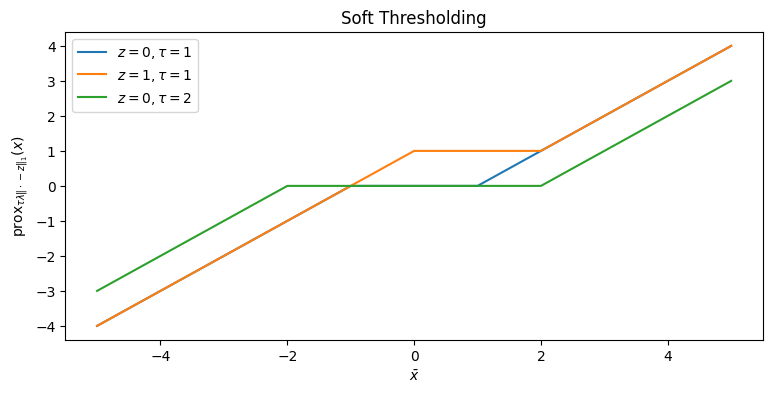

In [2]:
#Soft Thresholding Visualization

importlib.reload(rpca)
#visualize soft_thresholding
X = np.linspace(-5,5,101)
M = 1
lbda = 1
tau = 1
print(X.shape)

y  = rpca.soft_thresholding(xbar=X, z=0, tau=1)
y1 = rpca.soft_thresholding(xbar=X, z=1, tau=1)
y2 = rpca.soft_thresholding(xbar=X, z=0, tau=2)

fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(111)
ax1.set_title('Soft Thresholding')
# ax1.plot(X, X>M+tau*lbda)
# ax1.plot(X, X<M-tau*lbda)
# ax1.plot(X, np.abs(X-M)<=M)
# ax1.plot(X, np.abs(X-M))
ax1.plot(X, y,  label=r'$z=0, \tau=1$')
ax1.plot(X, y1, label=r'$z=1, \tau=1$')
ax1.plot(X, y2, label=r'$z=0, \tau=2$')
# ax1.axvline(0, color='tab:blue', linestyle='--')
# ax1.axvline(1, color='tab:orange', linestyle='--')
# ax1.axvline(1, color='tab:green', linestyle='--')
ax1.set_xlabel(r'$\bar x$')
ax1.set_ylabel(r'$\mathrm{prox}_{\tau\lambda\Vert\cdot-z\Vert_1}(x)$')
ax1.legend()
plt.show()

## Movie

In [3]:
# %matplotlib qt
# %matplotlib inline

def download_data(data_dir:str, download:bool=False):

    #download dataset
    ds = tfds.load(
        'davis',
        split='train[:1]',  #only one sample needed
        data_dir=f'{data_dir}tensorflow_datasets/',
        download=download,
        shuffle_files=False,
    )
    print(ds)

    #process samples (for testing of algorithm)
    for idx, ex in enumerate(tfds.as_numpy(ds)):
        
        name = ex['metadata']['video_name'].decode('utf-8')
        frames = ex['video']['frames']

        #convert to greyscale
        frames_gs = frames.mean(axis=-1)/255
        
        plt.imshow(frames_gs[0], cmap="gray")
        
        
        np.save(f'{data_dir}davis_{name}.npy', frames_gs)
        if idx > 1:
            break

def average_pooling(
    X:np.ndarray,
    kernel_size_x:int=1, kernel_size_y:int=1,
    ) -> np.ndarray:
    """
        - function executing average_pooling on a series of 2d image
            - will downsample the image by averaging patches of the image
        - used for dimensionality reduction during code-development
        - disabled before submission

        Parameters
        ----------
            - X
                - np.ndarray
                - input images
                - has shape (nsamples,xpixels,ypixels)
            - kernel_size
                - int
                - size of the kernel used for pooling
                - image will be split into (kernel_size,kernel_size) patches, which then get average
                    - the resulting values constitute the new image
        
        Returns
        -------
            - X_pooled
                - np.ndarray
                - image of lower resolution after average-pooling
                - has shape (X.shape[0], X.shape[1]//kernel_size, X.shape[2]//kernel_size)


    """

    #get dimensions
    N = X.shape[0]
    h, w = X.shape[1], X.shape[2]
    h_pooled, w_pooled = h//kernel_size_y, w//kernel_size_x
    print(h_pooled, w_pooled)

    #split into patches
    patches = X.reshape(N, h_pooled, kernel_size_y, w_pooled, kernel_size_x)

    #average pool
    X_pooled = np.mean(patches, axis=(2,4))

    return X_pooled


2024-09-13 09:43:43.676576: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 09:43:43.809394: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 09:43:44.220921: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 09:43:45.751174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<_PrefetchDataset element_spec={'metadata': {'num_frames': TensorSpec(shape=(), dtype=tf.int64, name=None), 'video_name': TensorSpec(shape=(), dtype=tf.string, name=None)}, 'video': {'frames': TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), 'segmentations': TensorSpec(shape=(None, None, None, 1), dtype=tf.uint8, name=None)}}>


2024-09-13 09:43:47.890926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X.shape=(80, 480, 854)
32 61
X_p.shape=(80, 32, 61)


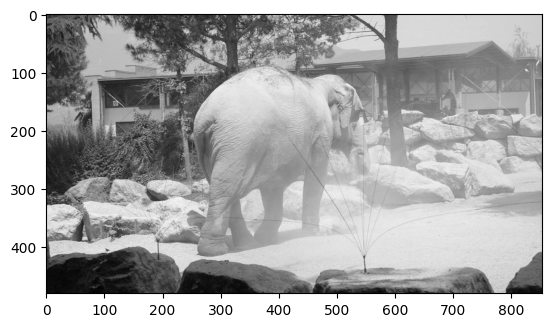

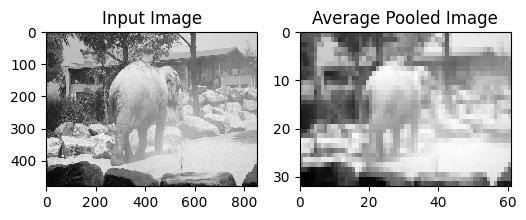

In [4]:
#%%load data
data_dir = f'./data/'


download_data(data_dir=data_dir, download=True)
X = np.load(f'{data_dir}davis_elephant.npy')[:,:,:]
print(f'{X.shape=}')

#average pool image for lower dimensionality
X_p = average_pooling(X, kernel_size_x=14, kernel_size_y=15)
print(f'{X_p.shape=}')

fig = plt.figure(figsize=(6,2))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Input Image')
ax2.set_title('Average Pooled Image')
ax1.pcolormesh(X[0], cmap='gray')
ax2.pcolormesh(X_p[0], cmap='gray')
ax1.invert_yaxis()
ax2.invert_yaxis()

# plt.pcolormesh(X, cmap='grey')

plt.show()


INFO(RPCA_ADMM.fit): Iteration 1 with delta= 0.0e+00, energy= 3.86e+02.
INFO(RPCA_ADMM.fit): Iteration 2 with delta= 1.2e-02, energy= 3.91e+02.
INFO(RPCA_ADMM.fit): Iteration 3 with delta= 1.3e-02, energy= 3.86e+02.
INFO(RPCA_ADMM.fit): Iteration 4 with delta= 1.0e-02, energy= 3.82e+02.
INFO(RPCA_ADMM.fit): Iteration 5 with delta= 8.0e-03, energy= 3.79e+02.
INFO(RPCA_ADMM.fit): Iteration 6 with delta= 6.3e-03, energy= 3.76e+02.
INFO(RPCA_ADMM.fit): Iteration 7 with delta= 5.0e-03, energy= 3.74e+02.
INFO(RPCA_ADMM.fit): Iteration 8 with delta= 4.1e-03, energy= 3.73e+02.
INFO(RPCA_ADMM.fit): Iteration 9 with delta= 3.4e-03, energy= 3.72e+02.
INFO(RPCA_ADMM.fit): Iteration 10 with delta= 2.9e-03, energy= 3.70e+02.
INFO(RPCA_ADMM.fit): Iteration 11 with delta= 2.5e-03, energy= 3.70e+02.
INFO(RPCA_ADMM.fit): Iteration 12 with delta= 2.1e-03, energy= 3.69e+02.
INFO(RPCA_ADMM.fit): Iteration 13 with delta= 1.8e-03, energy= 3.68e+02.
INFO(RPCA_ADMM.fit): Iteration 14 with delta= 1.6e-03, energ

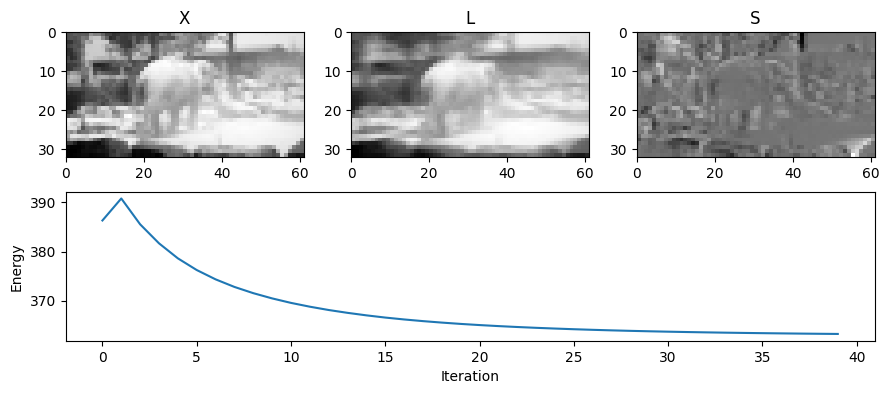

In [11]:
importlib.reload(rpca)
RPCA = rpca.RobustPCA(
    lbda=1e-2,
    tau=100, mu=1,
    max_iter=500,
    eps=1e-4,
    # method='chambolle_pock',
    method='admm',
    verbose=3,
)
X_train = X_p       #movie
# X_train = X_p[0]    #image

RPCA.fit(X_train, y=None, L0=None, S0=None, Y0=None)    #init with zeros
L, S = RPCA.transform(X=None, y=None)

fig = plt.figure(figsize=(9,4))
fig, axs, anim = RPCA.plot_result(
    X=X_train,
    L=L, S=S,
    fig=fig,
    animate=True,
    pcolormesh_kwargs=None,
    func_animation_kwargs=dict(repeat=False, frames=range(0,X_train.shape[0],1))  
)
for ax in axs[:-1]:
    ax.invert_yaxis()

# fig.savefig('rpca_elephant_cp.png')
# anim.save(f'./temp_rpca_movie_{RPCA.method}.gif')



## Astronomical Observations

In [287]:
#custom function to calculate variants of the fluxes
def sectornorm(
    X:np.ndarray, X_e:np.ndarray,
    sector:np.ndarray,
    ) -> np.ndarray[np.ndarray,np.ndarray]:
    """
        - function to compute a normalized version of X
        - computes
            - normalized X w.r.t. global median (and errors)
            - normalized X w.r.t. sectorwise median (and errors)
        
    """
    #initialize
    X_norm = np.empty((X.shape[0],2))
    X_norm_e = np.zeros_like(X_norm)*np.nan
    
    #compute fluxes and errors
    X_norm[:,0] = X/np.nanmedian(X)
    X_norm_e[:,0] = X_e/np.nanmedian(X)
    for s in np.unique(sector):
        sbool = (sector==s)
        X_norm[sbool,1] = X[sbool] / np.nanmedian(X[sbool])
        X_norm_e[sbool,1] = X_e[sbool] / np.nanmedian(X[sbool])
    
    return X_norm, X_norm_e


In [288]:
#%%load data
data_dir = f'./data/'


#load data
specs = dict(target="2018emt", lbda=7e-3, tau=1000, mu=0.1, eps=1e-6, max_iter=500)
# specs = dict(target="TVBoo",   lbda=3e-3, tau=700,  mu=10, eps=1e-6, max_iter=5000)


target = specs.pop("target")
tpfs = fits.open(f'{data_dir}{target}_tpfs.fits')
X_tpfs = tpfs[1].data.field('FLUX').copy()[:-50]
sectors = tpfs[1].data.field('SECTOR').copy()[:-50]

#get frame center
xpix, ypix = np.array(X_tpfs.shape[1:])//2
xpix = (xpix-1, xpix+1)
ypix = (ypix-1, ypix+1)

RobustPCA(
    lbda=0.007,
    tau=1000, mu=0.1,
    max_iter=500, eps=1e-06,
    theta=1.0,
    method='chambolle_pock',
    verbose=3,
)
INFO(RPCA_CP.fit): Iteration 1 with delta= 0.0e+00, energy= 2.58e+05.
INFO(RPCA_CP.fit): Iteration 2 with delta= 2.0e-02, energy= 2.52e+05.
INFO(RPCA_CP.fit): Iteration 3 with delta= 2.1e-02, energy= 2.47e+05.
INFO(RPCA_CP.fit): Iteration 4 with delta= 2.1e-02, energy= 2.42e+05.
INFO(RPCA_CP.fit): Iteration 5 with delta= 2.2e-02, energy= 2.37e+05.
INFO(RPCA_CP.fit): Iteration 6 with delta= 2.2e-02, energy= 2.31e+05.
INFO(RPCA_CP.fit): Iteration 7 with delta= 2.3e-02, energy= 2.26e+05.
INFO(RPCA_CP.fit): Iteration 8 with delta= 2.3e-02, energy= 2.21e+05.
INFO(RPCA_CP.fit): Iteration 9 with delta= 2.4e-02, energy= 2.16e+05.
INFO(RPCA_CP.fit): Iteration 10 with delta= 2.4e-02, energy= 2.10e+05.
INFO(RPCA_CP.fit): Iteration 11 with delta= 2.5e-02, energy= 2.05e+05.
INFO(RPCA_CP.fit): Iteration 12 with delta= 2.6e-02, energy= 2.00e+05.
INFO(RPCA_CP.fit):

(1232, 15, 12) (1232, 15, 12) (1232, 15, 12)


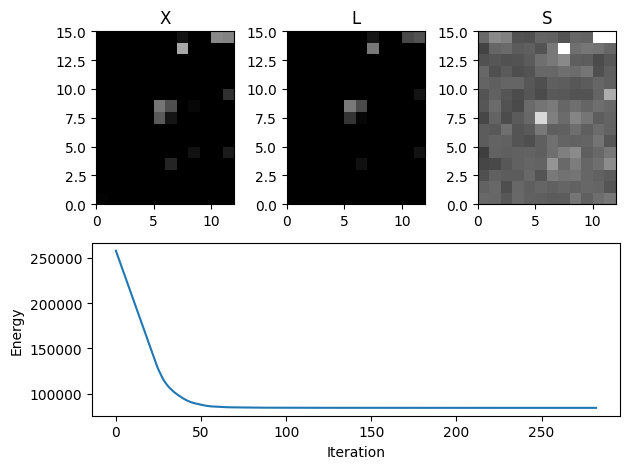

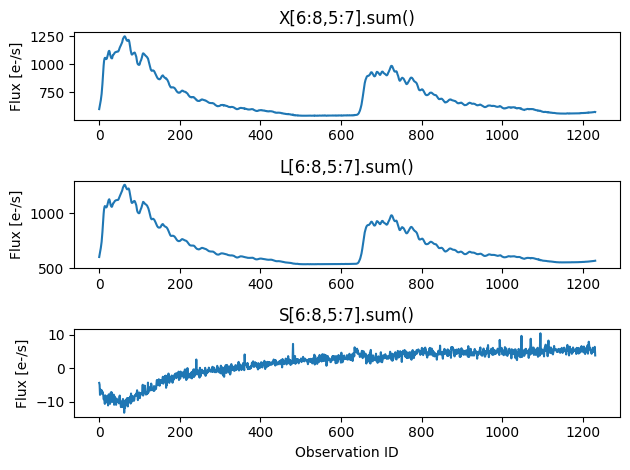

In [291]:
#%%train RPCA
importlib.reload(rpca)
RPCA = rpca.RobustPCA(
    # method='admm',
    method='chambolle_pock',
    verbose=3,
    **specs
)
print(RPCA)

X_train = X_tpfs
RPCA.fit(X_train, y=None, verbose=None)
L, S = RPCA.transform()
fig, axs, anim = RPCA.plot_result(
    X_train, L, S,
    animate=True,
    # pcolormesh_kwargs=dict(vmin=np.min([S]), vmax=np.max([S])),
    func_animation_kwargs=dict(repeat=False, frames=range(0,X_train.shape[0],50))
)

print(L.shape, S.shape, X_train.shape)

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_title(f'X[{xpix[0]}:{xpix[1]},{ypix[0]}:{ypix[1]}].sum()')
ax2.set_title(f'L[{xpix[0]}:{xpix[1]},{ypix[0]}:{ypix[1]}].sum()')
ax3.set_title(f'S[{xpix[0]}:{xpix[1]},{ypix[0]}:{ypix[1]}].sum()')
ax1.plot(X_train[:,xpix[0]:xpix[1],ypix[0]:ypix[1]].sum(axis=(1,2)))
ax2.plot(      L[:,xpix[0]:xpix[1],ypix[0]:ypix[1]].sum(axis=(1,2)))
ax3.plot(      S[:,xpix[0]:xpix[1],ypix[0]:ypix[1]].sum(axis=(1,2)))

# ax1.set_xlabel('Observation ID')
# ax2.set_xlabel('Observation ID')
ax3.set_xlabel('Observation ID')
ax1.set_ylabel('Flux [e-/s]')
ax2.set_ylabel('Flux [e-/s]')
ax3.set_ylabel('Flux [e-/s]')

fig.tight_layout()

# fig.savefig(f'./rpca_astro_{RPCA.method}.png')
# anim.save(f'./temp_rpca_{target}_{RPCA.method}.gif')
plt.show()


/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


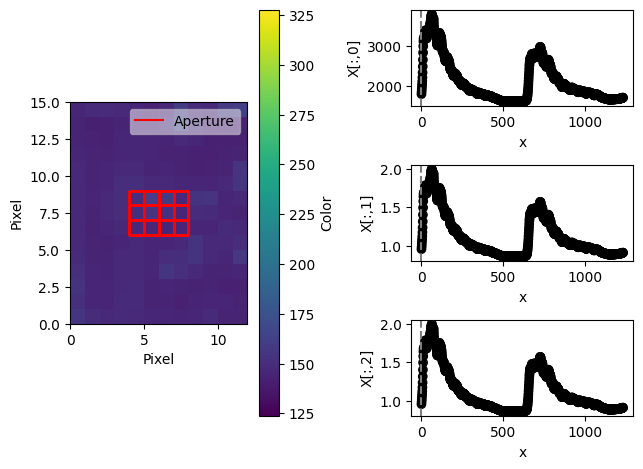

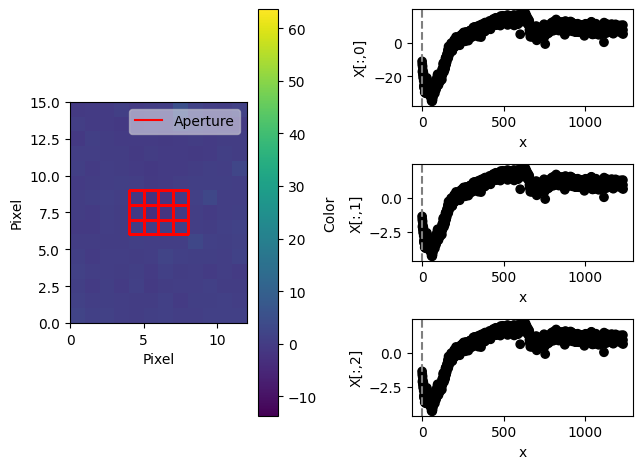

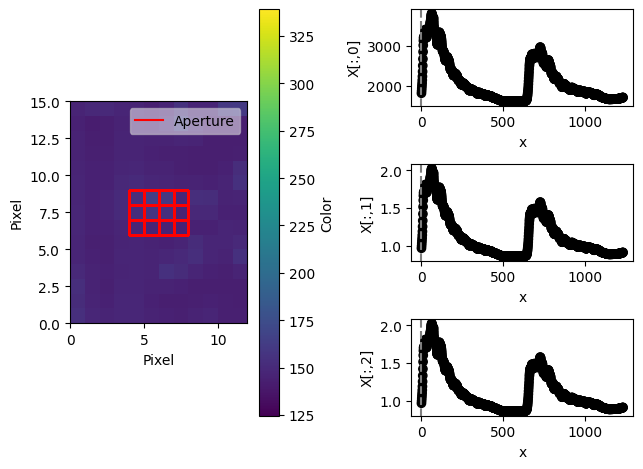

In [292]:
#%%get LCs
importlib.reload(aph)
X_in = [X_train, S, L]
AP = aph.AperturePhotometry(n_jobs=1, verbose=0)
lcs, lcs_e, apertures = AP.fit_transform(
    X_in,
    fit_kwargs=dict(
        fluxvars=sectornorm,
        apertures=2,
        fluxvars_kwargs=[dict(sector=sectors) for _ in range(3)],
        parallel_kwargs=dict(backend='threading'),
    )
)

for i in range(0, len(lcs)):
    fig, axs, anim = AP.plot_result(
        X=lcs[i], y=None,
        x_vals=None, X_in=X_in[i],
        aperture=apertures[i],
        pcolormesh_kwargs=None,
        sctr_kwargs=None,
        func_animation_kwargs=dict(repeat=False, frames=range(0,X_train.shape[0],50))
    )
    # anim.save(f'./temp_{target}_{"XSL"[i]}.gif')